In [21]:
import numpy as np
import matplotlib.pyplot as plt
from visanalysis.analysis import imaging_data
import os
from scipy import interpolate


In [22]:
experiment_file_name = '2022-10-27.hdf5'
experiment_file_directory = '/Users/mhturner/Desktop'
series_number = 5

In [23]:
file_path = os.path.join(experiment_file_directory, experiment_file_name)

# ImagingDataObject wants a path to an hdf5 file and a series number from that file
ID = imaging_data.ImagingDataObject(file_path,
                                    series_number,
                                    quiet=False)

roi_data = ID.getRoiResponses('proximal_roi')

===================TIMING: Channel 0======================
150 Stims presented (of 150 parameterized)
Stim start to start: [min=14.034, median=14.060, max=14.085] / parameterized = 14.000 sec
Stim duration: [min=9.992, median=9.992, max=10.009] / parameterized = 10.000 sec
Dropped 0 / 180002 frames (0.00%)
===================TIMING: Channel 1======================
150 Stims presented (of 150 parameterized)
Stim start to start: [min=14.034, median=14.060, max=14.085] / parameterized = 14.000 sec
Stim duration: [min=9.992, median=9.992, max=10.009] / parameterized = 10.000 sec
Dropped 0 / 180002 frames (0.00%)


In [24]:
roi_ind = 0
response_trace = roi_data.get('roi_response')[roi_ind][0, :]
response_time = np.arange(1, len(response_trace)+1) * ID.getAcquisitionMetadata('sample_period')
print
# Interpolation function to interpolate response. Fxn built using sample period
f_interp_response = interpolate.interp1d(response_time, response_trace)

def getRandVal(rand_min, rand_max, start_seed, update_rate, t):
  seed = int(round(start_seed + t*update_rate))
  np.random.seed(seed)
  return np.random.choice([rand_min, (rand_min + rand_max)/2, rand_max], size=1)[0]


In [25]:
filter_length = 3 # sec
epoch_parameters = ID.getEpochParameters()
ideal_frame_rate = 120  # Hz
sample_period = ID.getAcquisitionMetadata('sample_period') # (sec), bruker imaging acquisition period
filter_len = filter_length * ideal_frame_rate
stimulus_timing = ID.getStimulusTiming(plot_trace_flag=False)
stimulus_start_times = stimulus_timing['stimulus_start_times']
stim_frames = ID.getRunParameters('stim_time') * ideal_frame_rate
# frame flip times in a stimulus presentation:
stim_times = np.arange(1, stim_frames+1) * 1/ideal_frame_rate

all_trfs = []
all_stims = []
all_responses = []
for epoch_ind in range(int(ID.getRunParameters('num_epochs'))):
  # Regenerate the stimulus
  start_seed = epoch_parameters[epoch_ind]['start_seed']
  rand_min = eval(epoch_parameters[epoch_ind]['distribution_data'])['kwargs']['rand_min']
  rand_max = eval(epoch_parameters[epoch_ind]['distribution_data'])['kwargs']['rand_max']
  update_rate = epoch_parameters[epoch_ind]['update_rate']
  
  new_stim = np.array([getRandVal(rand_min, rand_max, start_seed, update_rate, t) for t in stim_times])
  current_frame_times = stimulus_start_times[epoch_ind] + stim_times  # In Prairie View time (sec)
  
  baseline_time = 1 # (sec) generally could be pre_time, but for opto only take previous 1 sec
  baseline_times = np.linspace(current_frame_times[0]-baseline_time, current_frame_times[0], int(1/sample_period))
  baseline = np.mean(f_interp_response(baseline_times))
  
  # Convert to dF/F
  current_interp_response = (f_interp_response(current_frame_times) - baseline) / baseline
  
  filter_fft = np.fft.fft(current_interp_response - np.mean(current_interp_response)) * np.conj(
      np.fft.fft(new_stim - np.mean(new_stim)))
    
  filt = np.real(np.fft.ifft(filter_fft))[0 : int(filter_len)]
  
  trf = np.flip(filt)
  all_trfs.append(trf)

all_trfs = np.stack(all_trfs, axis=-1)


===================TIMING: Channel 0======================
150 Stims presented (of 150 parameterized)
Stim start to start: [min=14.034, median=14.060, max=14.085] / parameterized = 14.000 sec
Stim duration: [min=9.992, median=9.992, max=10.009] / parameterized = 10.000 sec
Dropped 0 / 180002 frames (0.00%)
===================TIMING: Channel 1======================
150 Stims presented (of 150 parameterized)
Stim start to start: [min=14.034, median=14.060, max=14.085] / parameterized = 14.000 sec
Stim duration: [min=9.992, median=9.992, max=10.009] / parameterized = 10.000 sec
Dropped 0 / 180002 frames (0.00%)


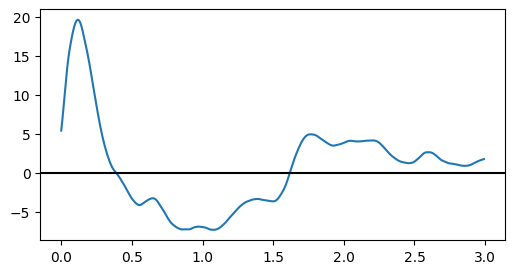

In [26]:
filter_time = np.flip(np.arange(0, filter_len) * 1/ideal_frame_rate)
fh, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(filter_time, np.mean(all_trfs, axis=-1))
ax.axhline(y=0, color='k')



In [ ]:
filter_fft.shape

Text(0, 0.5, 'Power')

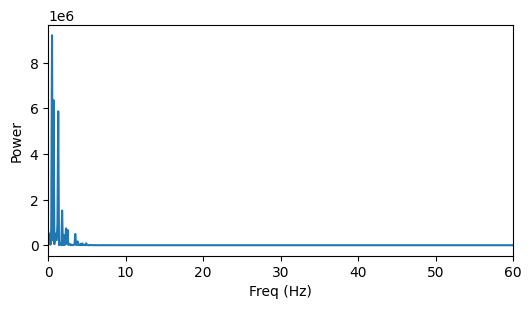

In [19]:
# Look at filter in fourier space

# FFT frequency sample points
freq = np.fft.fftfreq(n=len(filter_fft), d=1/ideal_frame_rate)

# Filter power spectrum
fh, ax = plt.subplots(1, 1, figsize=(6, 3))
# FFT shift before visualizing
ax.plot(np.fft.fftshift(freq), np.abs(np.fft.fftshift(filter_fft))**2)
# ax.plot(np.fft.fftshift(freq), np.fft.fftshift(filter_fft))

ax.set_xlim([0, 60])
# ax.set_yscale('log')
ax.set_xlabel('Freq (Hz)')
ax.set_ylabel('Power')


# Conclusion: very little power at high frequencies, no use in doing freq cutoff before ifft
